<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Translated by Gleb Filatov (@gleb_filatov). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose. This material is a translated version of the Capstone project (by the same author) from specialization "Machine learning and data analysis" by Yandex and MIPT. No solutions shared.

# <center> Project "Alice". User Identification Based on Visited Websites. Week 2.
## <center> Week 2. Data preparation, analysis, and hypothesis testing 
    
In the second week, we will continue to preprocess data both for further analysis and to train first machine learning models. Earlier we defined a session as a sequence of 10 websites visited by user. Now we will turn session length into a parameter and will choose best one with respect to fitted models. Also we will look at processed data, make some assumptions about data and test those assumtions via statistical hypothesis testing.

**Week 2 roadmap**
- Part 1. Preparing multiple training subsets
- Part 2. Basic data analysis, hypothesis testing

**You might find the following materials useful:**
- [Mathematical Biostatistics Boot Camp 1](https://www.coursera.org/learn/biostatistics) Coursera course
- Wikipedia pages on QQ-plots, Shapiro-Wilk criterion, Wilson confidence intervals, and bootstrap
   
**Besides, we are going to use [`pickle`](https://docs.python.org/3/library/pickle.html), [`glob`](https://docs.python.org/3/library/glob.html) and `Scipy.sparse` ([`csr_matrix`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.html) class) python libraries.**

**Your task**
1. Fill in the missing code in the provided notebook
2. Choose the answers in the [form](https://docs.google.com/forms/d/1a9GdBog7edZOQZEJKhoGL7tyXIZ0dAc8d-fiKMn7VfY)

## Part 1. Preparing multiple training subsets.

Earlier we assumed session length to be 10, and that was just a guess. Now let's make session length a parameter to be able to compare different classification models, trained on varying subsets - with 5, 7, 10 and 15 site visits in a sequence. Furthermore, we were taking 10 sites in succession, without any intersection. Now we will adopt sliding window idea, i.e. sessions will intersect.

**Example:** For session length of 10 and window width of 7, a file containing 30 entries will result not in 3 sessions, as before `(1-10, 11-20, 21-30)`, but in 5 sessions `(1-10, 8-17, 15-24, 22-30, 29-30)`. Also notice, that second-to-last session will have one zero and last session will have 8 zeroes. 

Let's create multiple subsets for different combinations of session length and window width parameters. All of them are presented in the table below. 

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length <span>&#8594;</span> <br>window_size <span>&#8595;</span> <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='red'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Now we should have 18 sparse matrices - 9 combinations shown above applied to subsets of 10 and 150 users. Two subsets were already created in previous assignment - those correspond to session_length = 10 and window_width = 10 (marked <font color="red"> Red </font> in the table above).

Implement function `prepare_sparse_train_set_window`.

**Function arguments:**
- path_to_csv_files - path to a directory, containing csv files
- site_freq_path - path to a pickle file with frequency dictionary, which you created in the previous assignment
- session_length - session length parameter
- window_size - window width parameter 

**Function should return two objects:**
- sparse matrix *X_sparse* (two-dimensional scipy.sparse.csr_matrix), where rows correspond to website sessions from *session_length* while columns of shape **max(site_id)** correspond to number of visits of *site_id* from session. 
- vector *y* (numpy array) of "true answers" - user's ID which produced a session from *X_sparse*

**Details:**
- Modify function `prepare_train_set` which was implemented in assignment 1
- Some sessions may repeat - leave it as is, do not remove duplicates
- Measure a loop's execution time using module *time* from package *time* or *tqdm* from *tqdm*
- you should be able to process 150 files from *capstone_websites_data/150users/* in a couple of seconds (depending on function parameters). If it takes longer time - it's okay, but you can speed up your implementation.

In [1]:
#disable Anaconda's warnings
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
# change the path to data if necessary
PATH_TO_DATA = '../../data/capstone_user_identification'

In [3]:
def process(lines, site_dict, session_length):
    session = []
    for line in lines:
        session.append(site_dict[line][0])
    if len(session) < session_length:
        for i in range(session_length - len(session)):
            session.append(0)
    return(session)

In [4]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    user_files = glob('/'.join([path_to_csv_files, '*.csv']))
    df = []
    freq = {}
    id_counter = 1
    site_dict = pd.read_pickle(site_freq_path)
    for user_file in user_files:
        with open(user_file, 'r') as file:
            user_id = int(user_file[-8:-4])
            file.readline()
            lines = []
            for line in file:
                lines.append(line.split(',')[1].replace('\n', ''))
                if len(lines) >= session_length:
                    session = process(lines, site_dict, session_length)
                    session.append(user_id)
                    df.append(session)
                    lines = lines[window_size:]
            while len(lines) > 0:
                session = process(lines, site_dict, session_length)
                session.append(user_id)
                df.append(session)
                for i in range(min([len(lines), window_size])):
                    lines.pop(0)
    column_names = ['site{}'.format(i) for i in range(1, session_length+1)]
    column_names.append('user_id')
    df = pd.DataFrame(df, columns = column_names)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X = csr_generator(X)
    return(X, y)

In [5]:
def csr_generator(X):
    indptr = [0]
    indices = []
    data = []
    for d in X:
        for term in d:
            index = term
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr_out = csr_matrix((data, indices, indptr), dtype=int)[:,1:]
    return(csr_out)

Apply the function with parameters *session_length=5* and *window_size=3* to the toy example. Make sure that everything works correctly.

In [6]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

In [7]:
X_toy_s5_w3.shape

(12, 11)

In [8]:
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [9]:
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [10]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3], dtype=int64)

In [11]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3], dtype=int64)

Execute the function 16 times iterating on number of users (*num_users*, 10 or 150), values of parameter *session_length* (15, 10, 7, 5) and values of parameter *window_size* (10, 7, 5). Serialize all 16 sparse matrices (training samples) and vectors (target class values - user IDs) in files 

X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl 

and 

y_{num_users}users_s{session_length}_w{window_size}.pkl.

To ensure, that from now on we will be working with identical objects, write number of rows in each of 16 sparse matrices in the list *data_lengths*. If some values will be identical, it is ok (you can deduce why).

On my laptop this code snippet executed in 26 seconds, but it obviously depends on how efficient your *prepare_sparse_train_set_window* implementation is and how powerful your hardware is. By the way my first implementation was not as good (34 minutes running time), so you have opportunity to improve your coding skills here. 

In [43]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, '{}users'.format(num_users)), 
                                                          os.path.join(PATH_TO_DATA, 'site_freq_{}users.pkl'.format(num_users)),
                                                          session_length=session_length, window_size=window_size)
            data_lengths.append(X_sparse.shape[0])
            with open(os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{}w{}.pkl'.format(num_users, session_length, window_size)), 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 'y_{}users_s{}w{}.pkl'.format(num_users, session_length, window_size)), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)

Wall time: 44.3 s


**<font color='red'> Question 1. </font> How many unique values are there in the list *data_lengths*?**

In [45]:
list(sorted(set(data_lengths)))

[14061, 20087, 28118, 137019, 195712, 273957]

## Part 2. Basic data analysis and hypothesis testing

Let's read the file **train_data_10users.csv** from first assignment in the dataframe. 

In [12]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [13]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


Target variable distribution:

In [15]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

Here we calculate the distribution of the number of unique websites in each session of length 10.

In [16]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [17]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

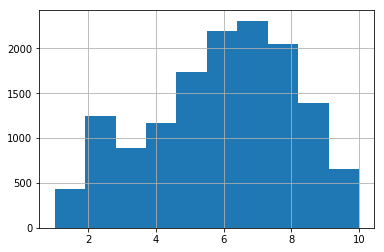

In [18]:
pd.Series(num_unique_sites).hist();

Using QQ-plot and Shapiro-Wilk criterion, verify the assumption, that this variable has normal distriburion.

**<font color='red'>Question 2.</font> Is the number of unique websites in each session normally distributed (according to the Shapiro-Wilk criterion)?**

((array([-3.89403843, -3.6734386 , -3.55253248, ...,  3.55253248,
          3.6734386 ,  3.89403843]), array([ 1,  1,  1, ..., 10, 10, 10])),
 (2.3087399107781477, 5.951923760756702, 0.9770787039552055))

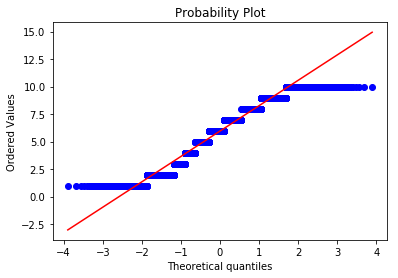

In [19]:
stats.probplot(num_unique_sites, plot=plt)

In [20]:
stats.shapiro(num_unique_sites)

(0.9546933174133301, 0.0)

Test the following hypothesis: at least once, a user will visit the site, that he/she visited previously (in the session of 10 sites).  

Here we stick to binomial criterion to show, that the fraction of cases, where user visited the website again (that is, number of unique sites in session is less than 10) is big enough - bigger than 95%. Notice, that this criterion is one-sided. 

**<font color='red'>Question 3.</font> What's the p-value in the described hypothesis checking?**

In [21]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [22]:
stats.binom_test(np.sum(has_two_similar), len(has_two_similar), p=.95, alternative='greater')

0.02207653769072678

**<font color='red'>Question 4.</font> What's the 95% Wilson confidence interval for the fraction of cases when a user re-visited a site?**

In [23]:
wilson_interval = proportion_confint(np.sum(has_two_similar), len(has_two_similar), alpha=0.05, method='wilson')

In [24]:
print('{} {}'.format(round(wilson_interval[0], 3),
                     round(wilson_interval[1], 3)))

0.95 0.957


Calculate the frequency distribution of website visits (how many times website appears in a session) for websites, that were visited at least 1000 times.

In [127]:
sites = np.unique(train_df.iloc[:, :-1].values.reshape(-1))
freqs = {x:0 for x in sites}
for i in range(train_df.shape[0]):
    sites = train_df.values[i, :-1]
    for site in sites:
        freqs[site] += 1
freqs.pop(0)

36

Calculate 95% confidence interval for average website frequency in the whole sample (not only those, which were visited at least 1000 times) using bootstrap technique. Use the amount of bootstrapped subsamples equal to the number of sites in the initial sample of 10 users. Use subsamples from the list of frequencies you have just calculcated, no need to recalculate them. Notice, that frequency of encountering 0 (index 0 appeared only in the sessions shorter than 10) should be removed. Round interval endpoints to 3 digits. This will be the answer to question 5 in the webform.

**<font color='red'>Question 5.</font>  What's the 95% confidence interval for average website frequency?**

In [128]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [129]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [131]:
q5 = get_bootstrap_samples(np.array(list(freqs.values())), len(freqs))
bootstrap_frequencies = np.apply_along_axis(np.mean, 1, q5)
stat_intervals(bootstrap_frequencies, 0.05)

array([22.51524527, 35.76303684])

Next week, we will be doing exploratory data analysis via plots as well as creating useful features for further machine learning models.